# 1-1(a)

In [1]:
import numpy as np
import requests
import matplotlib.pyplot as plt

train_x, train_y = np.load('fashion_mnist/train_x.npy'), np.load('fashion_mnist/train_y.npy')
test_x, test_y = np.load('fashion_mnist/test_x.npy'), np.load('fashion_mnist/test_y.npy')

print('shape of data:')
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)
print()

checkpoint = np.load('weights.npy', allow_pickle=True).item()
init_weights = checkpoint['w']
init_biases = checkpoint['b']

print('shape of weights:')
for w in init_weights:
    print(w.shape)

print()

print('shape of biases:')
for b in init_biases:
    print(b.shape)
    
#normalize
train_x = train_x/255
test_x = test_x/255

#train_y、test_y one hot encode
def encode(y_neeed_encode):
    y_encoded = []
    for num in y_neeed_encode:
        temp = [0,0,0,0,0]
        temp[num] = 1
        y_encoded.append(temp)

    y_encoded = np.array(y_encoded)
    return(y_encoded) 

train_y_encoded = encode(train_y)
test_y_encoded = encode(test_y)

shape of data:
(30000, 784)
(30000,)
(5000, 784)
(5000,)

shape of weights:
(784, 2048)
(2048, 512)
(512, 5)

shape of biases:
(2048,)
(512,)
(5,)


In [2]:
def forward(input_x, weights, biases):
    # 第一層 (784, 2048)
    h1_input = np.dot(input_x,weights[0]) # 第一層 hidden layer neuron input
    h1_input = h1_input+biases[0] # 加上 bias
    h1_output = np.maximum(h1_input, 0) # 第一層 hidden layer neuron output (relu)

    # 第二層 (2048, 512)
    h2_input = np.dot(h1_output,weights[1]) # 第二層 hidden layer neuron input
    h2_input = h2_input+biases[1] # 加上 bias
    h2_output = np.maximum(h2_input, 0) # 第二層 hidden layer neuron output (relu)

    # 第三層 (output layer) (512, 5)
    h3_input = np.dot(h2_output,weights[2]) # 第三層 hidden layer neuron input
    h3_input = h3_input+biases[2] # 加上 bias
    h3_output = softmax(h3_input) # 第三層 hidden layer neuron output (softmax)

    return h1_output, h2_output, h3_output

def softmax(x):
    exp_max = np.exp(x - np.max(x,axis=-1,keepdims=True))
    out = exp_max/np.sum(exp_max,axis=-1,keepdims=True)
    return out

def FNN(train_x, train_y_encoded, test_x, test_y_encoded, init_weights, init_biases, epoch, learning_rate, batch_size):

    loss_train = []
    accuracy_train = []
    loss_test = []
    accuracy_test = []
    
    weights = init_weights[:]
    biases = init_biases[:]
    
    gradw1 = np.zeros((784, 2048))
    gradw2 = np.zeros((2048, 512))
    gradw3 = np.zeros((512, 5))

    gradb1 = np.zeros((1, 2048))
    gradb2 = np.zeros((1, 512))
    gradb3 = np.zeros((1, 5))

    for i in range(0, epoch):   
        for j in range(0, train_x.shape[0], batch_size):
            
            ################################## forward pass ###################################
            
            h1_output, h2_output, h3_output = forward(train_x[j:j+batch_size], weights, biases)
            
            ################################# backpropagation #######################################
            
            delta3 = h3_output - train_y_encoded[j:j+batch_size] #batch_size*5

            derv_act_2 = h2_output[:] # batch_size*512
            derv_act_2[derv_act_2>0] = 1 # dRelu, batch_size*512
            error_3 = np.dot(weights[2], delta3.T) # 512*5, 5*batch_size = 512*batch_size                        
            delta2 = np.multiply(error_3.T, derv_act_2) # batch_size*512                              

            derv_act_1 = h1_output[:]                                             
            error_2 = np.dot(weights[1], delta2.T)                                    
            delta1 = np.multiply(error_2.T, derv_act_1)                              

            # Grad = Delta dot Output of previous Layer
            gradw3 = np.dot(h2_output.T,delta3)/batch_size           
            gradw2 = np.dot(h1_output.T,delta2)/batch_size       
            gradw1 = np.dot(train_x[j:j+batch_size].T,delta1)/batch_size       
            gradb3 = np.sum(delta3,axis=0)/batch_size                                                      
            gradb2 = np.sum(delta2,axis=0)/batch_size                                                        
            gradb1 = np.sum(delta1,axis=0)/batch_size

            # Update weight
            weights[2] = weights[2]-learning_rate*gradw3
            weights[1] = weights[1]-learning_rate*gradw2
            weights[0] = weights[0]-learning_rate*gradw1
            biases[2] = biases[2]-learning_rate*gradb3
            biases[1] = biases[1]-learning_rate*gradb2
            biases[0] = biases[0]-learning_rate*gradb1

            # 每 50 個 iter print iter 資訊
            iter_num = (j+batch_size)/batch_size
            if iter_num%50 == 0:
                
                # 計算 test 的 acc、loss
                h1_output, h2_output, h3_output = forward(test_x, weights, biases)
                loss_test.append(np.sum(-(np.sum(test_y_encoded*np.log(np.clip(h3_output, 1e-7, 1 - 1e-7)), axis=1)))/test_x.shape[0])
                accuracy_test.append(np.sum(h3_output.argmax(axis=1)==test_y_encoded.argmax(axis=1))/test_x.shape[0])

                # 計算 train 的 acc、loss
                h1_output, h2_output, h3_output = forward(train_x[j:j+batch_size], weights, biases)
                loss_train.append(np.sum(-(np.sum(train_y_encoded[j:j+batch_size] * np.log(np.clip(h3_output, 1e-7, 1 - 1e-7)), axis=1)))/batch_size)
                accuracy_train.append(np.sum(h3_output.argmax(axis=1)==train_y_encoded[j:j+batch_size].argmax(axis=1))/batch_size)
                
                # print iter 資訊
                print("epoch=",i+1,"iter=",iter_num)
                print("Train: ","loss=",loss_train[-1],"accuracy=",accuracy_train[-1])
                print("Test:  ","loss=",loss_test[-1],"accuracy=",accuracy_test[-1])
                print("---------------------------------------------------")

            # 重置 gradient 為 0
            gradw1 = np.zeros((784, 2048))
            gradw2 = np.zeros((2048, 512))
            gradw3 = np.zeros((512, 5))
            gradb1 = np.zeros((1, 2048))
            gradb2 = np.zeros((1, 512))
            gradb3 = np.zeros((1, 5))
    
    # 畫圖
    x_list = [x for x in range(50,150*epoch+1,50)] 
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(12, 4)
    ax[0].set_title('Learning Cruve', color='r')
    ax[0].set_xlabel('Number of iterations')
    ax[0].set_ylabel('Cross Entropy')
    ax[0].plot(x_list, loss_train, label = 'train')
    ax[0].plot(x_list, loss_test, label = 'test')
    ax[0].legend(loc=1)

    ax[1].set_title('Accuracy', color='r')
    ax[1].set_xlabel('Number of iterations')
    ax[1].set_ylabel('Accuracy')
    ax[1].plot(x_list, accuracy_train, label = 'train')
    ax[1].plot(x_list, accuracy_test, label = 'test')
    ax[1].legend(loc=4)
    
    return weights, biases, loss_train, accuracy_train, loss_test, accuracy_test


epoch= 1 iter= 50.0
Train:  loss= 0.6447239220383377 accuracy= 0.96
Test:   loss= 0.5611474083113007 accuracy= 0.965
---------------------------------------------------
epoch= 1 iter= 100.0
Train:  loss= 0.6659722976204466 accuracy= 0.955
Test:   loss= 0.5823980564992457 accuracy= 0.9638
---------------------------------------------------
epoch= 1 iter= 150.0
Train:  loss= 0.16118105550958817 accuracy= 0.99
Test:   loss= 0.4869304411059275 accuracy= 0.9696
---------------------------------------------------
epoch= 2 iter= 50.0
Train:  loss= 0.4835429665287546 accuracy= 0.97
Test:   loss= 0.476779962938883 accuracy= 0.97
---------------------------------------------------
epoch= 2 iter= 100.0
Train:  loss= 0.2417715332643797 accuracy= 0.985
Test:   loss= 0.4895532776817403 accuracy= 0.9694
---------------------------------------------------
epoch= 2 iter= 150.0
Train:  loss= 0.08059057775479653 accuracy= 0.995
Test:   loss= 0.46121117555346536 accuracy= 0.9712
--------------------------

epoch= 17 iter= 50.0
Train:  loss= 1.0177537658574767e-07 accuracy= 1.0
Test:   loss= 0.37370474196729064 accuracy= 0.9768
---------------------------------------------------
epoch= 17 iter= 100.0
Train:  loss= 1.0000000494736474e-07 accuracy= 1.0
Test:   loss= 0.3664787114879378 accuracy= 0.9772
---------------------------------------------------
epoch= 17 iter= 150.0
Train:  loss= 1.0000000494736474e-07 accuracy= 1.0
Test:   loss= 0.38105180020161383 accuracy= 0.9762
---------------------------------------------------
epoch= 18 iter= 50.0
Train:  loss= 1.0000000494736474e-07 accuracy= 1.0
Test:   loss= 0.3803871550026212 accuracy= 0.9764
---------------------------------------------------
epoch= 18 iter= 100.0
Train:  loss= 1.0000000494736474e-07 accuracy= 1.0
Test:   loss= 0.378523987505336 accuracy= 0.9764
---------------------------------------------------
epoch= 18 iter= 150.0
Train:  loss= 1.0000000494736474e-07 accuracy= 1.0
Test:   loss= 0.36837177654245834 accuracy= 0.977
---

C:\Users\ECLAB\anaconda3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


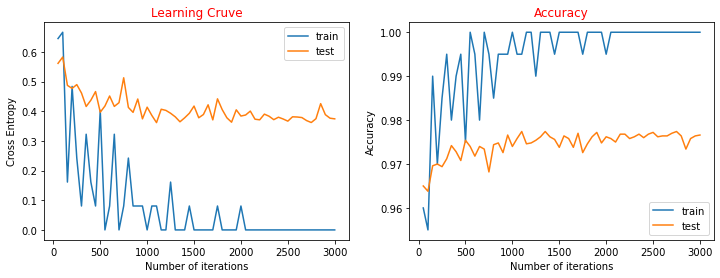

In [3]:
epoch = 20
learning_rate = 0.001
batch_size = 200
weights_1_1, biases_1_1, loss_train_list_1_1, accuracy_train_list_1_1, loss_test_list_1_1, accuracy_test_list_1_1 = FNN(train_x, train_y_encoded, test_x, test_y_encoded, init_weights, init_biases, epoch, learning_rate, batch_size)

# 儲存訓練完成的參數，1-3 題要用到
np.save('trained_weights_FNN', weights_1_1)
np.save('trained_biases_FNN', biases_1_1)

# 1-1(b) 
### 初始化 weights、biases 為 0 ，導致 forword pass neurons output 是 0 ，因此 Backpropagation 得到的 gradient 也為 0，所以沒辦法做參數更新，無法成功training

epoch= 1 iter= 50.0
Train:  loss= 1.6094407188488247 accuracy= 0.19
Test:   loss= 1.6094379362527234 accuracy= 0.2
---------------------------------------------------
epoch= 1 iter= 100.0
Train:  loss= 1.6094401935866736 accuracy= 0.235
Test:   loss= 1.6094379151942597 accuracy= 0.2
---------------------------------------------------
epoch= 1 iter= 150.0
Train:  loss= 1.6094383150926144 accuracy= 0.145
Test:   loss= 1.609437912439345 accuracy= 0.2
---------------------------------------------------
epoch= 2 iter= 50.0
Train:  loss= 1.6094407785125509 accuracy= 0.19
Test:   loss= 1.609437935582623 accuracy= 0.2
---------------------------------------------------
epoch= 2 iter= 100.0
Train:  loss= 1.6094398936294767 accuracy= 0.235
Test:   loss= 1.6094379149898 accuracy= 0.2
---------------------------------------------------
epoch= 2 iter= 150.0
Train:  loss= 1.6094387058610051 accuracy= 0.145
Test:   loss= 1.609437912454463 accuracy= 0.2
------------------------------------------------

epoch= 17 iter= 100.0
Train:  loss= 1.6094363253933872 accuracy= 0.235
Test:   loss= 1.6094379133302719 accuracy= 0.2
---------------------------------------------------
epoch= 17 iter= 150.0
Train:  loss= 1.6094433562872288 accuracy= 0.145
Test:   loss= 1.6094379133923922 accuracy= 0.2
---------------------------------------------------
epoch= 18 iter= 50.0
Train:  loss= 1.6094415262480544 accuracy= 0.19
Test:   loss= 1.6094379280644309 accuracy= 0.2
---------------------------------------------------
epoch= 18 iter= 100.0
Train:  loss= 1.6094361398767045 accuracy= 0.235
Test:   loss= 1.6094379132829952 accuracy= 0.2
---------------------------------------------------
epoch= 18 iter= 150.0
Train:  loss= 1.609443598164971 accuracy= 0.145
Test:   loss= 1.6094379134794234 accuracy= 0.2
---------------------------------------------------
epoch= 19 iter= 50.0
Train:  loss= 1.6094415621599123 accuracy= 0.19
Test:   loss= 1.6094379277442614 accuracy= 0.2
-------------------------------------

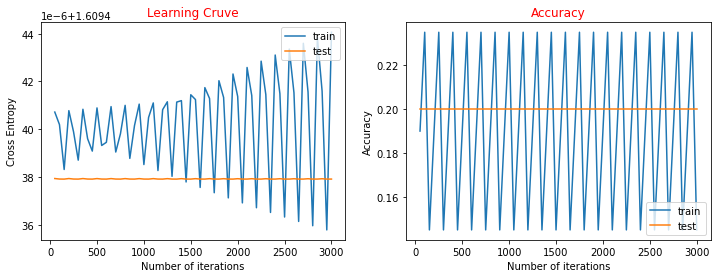

In [4]:
epoch = 20
learning_rate = 0.001
batch_size = 200

z_weights = []
z_weights.append(np.zeros((784, 2048)))
z_weights.append(np.zeros((2048, 512)))
z_weights.append(np.zeros((512, 5)))

z_biases = []
z_biases.append(np.zeros((1, 2048)))
z_biases.append(np.zeros((1, 512)))
z_biases.append(np.zeros((1, 5)))


weights_1_1, biases_1_1, loss_train_list_1_1, accuracy_train_list_1_1, loss_test_list_1_1, accuracy_test_list_1_1 = FNN(train_x, train_y_encoded, test_x, test_y_encoded, z_weights, z_biases, epoch, learning_rate, batch_size)

# 1-2(a)

In [5]:
def forward_with_dropout(input_x, weights, biases, dropout_rate):
    # 第一層 (784, 2048)
    h1_input = np.dot(input_x,weights[0]) # 第一層 hidden layer neuron input
    h1_input = h1_input+biases[0] # 加上 bias
    h1_output = np.maximum(h1_input, 0) # 第一層 hidden layer neuron output (relu)
    rand = np.random.choice(np.arange(2048), size=int(2048*dropout_rate), replace=False)
    h1_output.T[rand,:] = 0
    
    # 第二層 (2048, 512)
    h2_input = np.dot(h1_output,weights[1]) # 第二層 hidden layer neuron input
    h2_input = h2_input+biases[1] #加上bias
    h2_output = np.maximum(h2_input, 0) # 第二層 hidden layer neuron output (relu)
    rand = np.random.choice(np.arange(512), size=int(512*dropout_rate), replace=False)
    h2_output.T[rand,:] = 0
    
    # 第三層 (output layer) (512, 5)
    h3_input = np.dot(h2_output,weights[2]) # 第三層 hidden layer neuron input
    h3_input = h3_input+biases[2] # 加上 bias
    h3_output = softmax(h3_input) # 第三層 hidden layer neuron output (softmax)

    return h1_output, h2_output, h3_output

def FNN_Dropout(train_x, train_y_encoded, test_x, test_y_encoded, init_weights, init_biases, epoch, learning_rate, batch_size, dropout_rate):

    loss_train = []
    accuracy_train = []
    loss_test = []
    accuracy_test = []
    
    weights = init_weights[:]
    biases = init_biases[:]
    
    gradw1 = np.zeros((784, 2048))
    gradw2 = np.zeros((2048, 512))
    gradw3 = np.zeros((512, 5))

    gradb1 = np.zeros((1, 2048))
    gradb2 = np.zeros((1, 512))
    gradb3 = np.zeros((1, 5))

    for i in range(0, epoch):   
        for j in range(0, train_x.shape[0], batch_size):
            
            ################################## forward pass ###################################
            
            h1_output, h2_output, h3_output = forward_with_dropout(train_x[j:j+batch_size], weights, biases, dropout_rate)
            
            ################################# backpropagation #######################################
            
            delta3 = h3_output - train_y_encoded[j:j+batch_size] # batch_size*5

            derv_act_2 = h2_output[:] # batch_size*512
            derv_act_2[derv_act_2>0] = 1 # dRelu, batch_size*512
            error_3 = np.dot(weights[2], delta3.T) # 512*5, 5*batch_size = 512*batch_size                        
            delta2 = np.multiply(error_3.T, derv_act_2) # batch_size*512                              

            derv_act_1 = h1_output[:]                                             
            error_2 = np.dot(weights[1], delta2.T)                                    
            delta1 = np.multiply(error_2.T, derv_act_1)                              

            # Grad = Delta dot Output of previous Layer
            gradw3 = np.dot(h2_output.T,delta3)/batch_size           
            gradw2 = np.dot(h1_output.T,delta2)/batch_size       
            gradw1 = np.dot(train_x[j:j+batch_size].T,delta1)/batch_size       
            gradb3 = np.sum(delta3,axis=0)/batch_size                                                      
            gradb2 = np.sum(delta2,axis=0)/batch_size                                                        
            gradb1 = np.sum(delta1,axis=0)/batch_size

            # Update weight
            weights[2] = weights[2]-learning_rate*gradw3
            weights[1] = weights[1]-learning_rate*gradw2
            weights[0] = weights[0]-learning_rate*gradw1
            biases[2] = biases[2]-learning_rate*gradb3
            biases[1] = biases[1]-learning_rate*gradb2
            biases[0] = biases[0]-learning_rate*gradb1

            # 每 50 個 iter print iter 資訊
            iter_num = (j+batch_size)/batch_size
            if iter_num%50 == 0:
                
                # 計算 test 的 acc、loss
                h1_output, h2_output, h3_output = forward(test_x, weights, biases)
                loss_test.append(np.sum(-(np.sum(test_y_encoded*np.log(np.clip(h3_output, 1e-7, 1 - 1e-7)), axis=1)))/test_x.shape[0])
                accuracy_test.append(np.sum(h3_output.argmax(axis=1)==test_y_encoded.argmax(axis=1))/test_x.shape[0])

                # 計算 train 的 acc、loss
                h1_output, h2_output, h3_output = forward(train_x[j:j+batch_size], weights, biases)
                loss_train.append(np.sum(-(np.sum(train_y_encoded[j:j+batch_size] * np.log(np.clip(h3_output, 1e-7, 1 - 1e-7)), axis=1)))/batch_size)
                accuracy_train.append(np.sum(h3_output.argmax(axis=1)==train_y_encoded[j:j+batch_size].argmax(axis=1))/batch_size)
                
                # print iter 資訊
                print("epoch=",i+1,"iter=",iter_num)
                print("Train: ","loss=",loss_train[-1],"accuracy=",accuracy_train[-1])
                print("Test:  ","loss=",loss_test[-1],"accuracy=",accuracy_test[-1])
                print("---------------------------------------------------")

            # 重置 gradient 為 0
            gradw1 = np.zeros((784, 2048))
            gradw2 = np.zeros((2048, 512))
            gradw3 = np.zeros((512, 5))
            gradb1 = np.zeros((1, 2048))
            gradb2 = np.zeros((1, 512))
            gradb3 = np.zeros((1, 5))
    
    # 畫圖
    x_list = [x for x in range(50,150*epoch+1,50)] 
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(12, 4)
    ax[0].set_title('Learning Cruve', color='r')
    ax[0].set_xlabel('Number of iterations')
    ax[0].set_ylabel('Cross Entropy')
    ax[0].plot(x_list, loss_train, label = 'train')
    ax[0].plot(x_list, loss_test, label = 'test')
    ax[0].legend(loc=1)

    ax[1].set_title('Accuracy', color='r')
    ax[1].set_xlabel('Number of iterations')
    ax[1].set_ylabel('Accuracy')
    ax[1].plot(x_list, accuracy_train, label = 'train')
    ax[1].plot(x_list, accuracy_test, label = 'test')
    ax[1].legend(loc=4)
    
    return weights, biases, loss_train, accuracy_train, loss_test, accuracy_test


epoch= 1 iter= 50.0
Train:  loss= 0.8602217463220242 accuracy= 0.945
Test:   loss= 0.7220582016421797 accuracy= 0.955
---------------------------------------------------
epoch= 1 iter= 100.0
Train:  loss= 0.5641334442835461 accuracy= 0.965
Test:   loss= 0.5387417053965337 accuracy= 0.9664
---------------------------------------------------
epoch= 1 iter= 150.0
Train:  loss= 0.16118105550958814 accuracy= 0.99
Test:   loss= 0.4899902047491378 accuracy= 0.9696
---------------------------------------------------
epoch= 2 iter= 50.0
Train:  loss= 0.5641334442835461 accuracy= 0.965
Test:   loss= 0.47659231519021394 accuracy= 0.9702
---------------------------------------------------
epoch= 2 iter= 100.0
Train:  loss= 0.6447239220383375 accuracy= 0.96
Test:   loss= 0.6078194160277398 accuracy= 0.9622
---------------------------------------------------
epoch= 2 iter= 150.0
Train:  loss= 0.08059057775479656 accuracy= 0.995
Test:   loss= 0.48354296652875445 accuracy= 0.97
-----------------------

epoch= 17 iter= 50.0
Train:  loss= 0.08059057775479651 accuracy= 0.995
Test:   loss= 0.29024349329685634 accuracy= 0.982
---------------------------------------------------
epoch= 17 iter= 100.0
Train:  loss= 0.08059057775479651 accuracy= 0.995
Test:   loss= 0.293351514627062 accuracy= 0.9818
---------------------------------------------------
epoch= 17 iter= 150.0
Train:  loss= 0.16118105550958817 accuracy= 0.99
Test:   loss= 0.28367858169687127 accuracy= 0.9824
---------------------------------------------------
epoch= 18 iter= 50.0
Train:  loss= 0.08059057775479651 accuracy= 0.995
Test:   loss= 0.28448049891361127 accuracy= 0.9822
---------------------------------------------------
epoch= 18 iter= 100.0
Train:  loss= 0.24177153326437967 accuracy= 0.985
Test:   loss= 0.27639361585473227 accuracy= 0.9826
---------------------------------------------------
epoch= 18 iter= 150.0
Train:  loss= 0.08059057775479653 accuracy= 0.995
Test:   loss= 0.26111328094878 accuracy= 0.9838
-----------

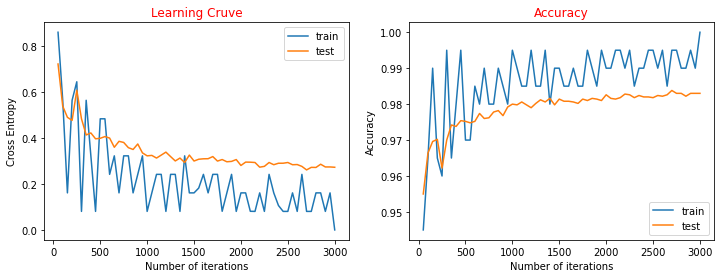

In [6]:
epoch = 20
learning_rate = 0.001
batch_size = 200
dropout_rate = 0.2
weights_1_2, biases_1_2, loss_train_list_1_2, accuracy_train_list_1_2, loss_test_list_1_2, accuracy_test_list_1_2 = FNN_Dropout(train_x, train_y_encoded, test_x, test_y_encoded, init_weights, init_biases, epoch, learning_rate, batch_size, dropout_rate)

# 1-2(b)
### Dropout 可以減少模型 overfitting 的機率，如上圖 training accuracy 不會持續維持在1，而是會有震盪的情況，這樣的隨機性有助於模型的 generalization ， 因此上圖的 testing data accuracy ， 相較於沒有加入 Dropout 的 model 是比較穩定地成長，沒有太大的波動，且 testing data accuracy 最後為 0.983 ，高於沒有加 Dropout 的 testing data accuracy 0.9766 (1-1 (a) 小題的結果)。

# 1-3(a)

In [7]:
#np.random.seed(123)
init_train_x = np.random.randint(256, size=(256, 784)) # 隨機產生 256 張圖，數值介於 0~255
#np.random.seed(123)
train_y_new = np.random.randint(5, size=256) # 隨機產生 256 個 target
train_y_encoded_new = encode(train_y_new)
#normalize
train_x_new = (init_train_x/255)[:]

In [8]:
# 載入 1-1(a) 訓練得到的模型參數
weights = np.load('trained_weights_FNN.npy',allow_pickle=True)
biases = np.load('trained_biases_FNN.npy',allow_pickle=True)

accuracy_train_list = []
learning_rate = 0.1
iteration_num = 5

for i in range(iteration_num+1):
    acc_count_train = 0
    for j in range(train_x_new.shape[0]):
        
        ################################## forward pass ##################################
        
        h1_output, h2_output, h3_output = forward(train_x_new[j], weights, biases)
        if h3_output.argmax() == train_y_encoded_new[j].argmax():
            acc_count_train+=1
            
        ################################# backpropagation #######################################
        
        delta3 = h3_output - train_y_encoded_new[j]
        
        derv_act_2 = h2_output[:] 
        derv_act_2[derv_act_2>0] = 1                                            
        error_3 = np.dot(weights[2], delta3.T)                                    
        delta2 = np.multiply(error_3.T, derv_act_2)     
        
        derv_act_1 = h1_output[:] 
        derv_act_1[derv_act_1>0] = 1                                           
        error_2 = np.dot(weights[1], delta2.T)                                    
        delta1 = np.multiply(error_2.T, derv_act_1)

        derv_act_0 = np.ones(train_x_new[j].shape[0])                                             
        error_1 = np.dot(weights[0], delta1.T)                                    
        delta0 = np.multiply(error_1.T, derv_act_0)

        train_x_new[j] = train_x_new[j] - learning_rate*delta0
        train_x_new[j] = np.clip(train_x_new[j], 0 ,1)

    accuracy_train_list.append(acc_count_train/train_x_new.shape[0])
    print("iter=", i, "accuracy=", accuracy_train_list[-1])

iter= 0 accuracy= 0.2109375
iter= 1 accuracy= 0.99609375
iter= 2 accuracy= 0.99609375
iter= 3 accuracy= 1.0
iter= 4 accuracy= 1.0
iter= 5 accuracy= 1.0


# 1-3(b) 
### 印出 5 iterations 後的各一種類別圖片結果發現，圖片預測雖然準確率為 1 ，但是圖片並沒有明顯的 feature ，這可能是因為 input 對 target 的 overfitting 導致。 

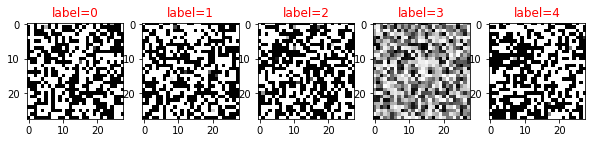

In [9]:
import matplotlib.pyplot as plt
train_y_new_list = train_y_new.tolist()
indexes = [train_y_new_list.index(x) for x in set(train_y_new_list)] # 挑出五種類別，各自對應的 index

fig, ax = plt.subplots(1, 5)
fig.set_size_inches(10, 10)

for i in range(5):
    ax[i].set_title("label="+str(train_y_new_list[indexes[i]]), color='r')
    ax[i].imshow((train_x_new[indexes[i]]*255).reshape(28,28), cmap = 'Greys_r')